「論文のタイトルから医療関連の論文かどうかを判定する」タスクを解くに際して、どのモデルが良いのかを検証します。

In [1]:
import collections
import functools
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
from openai import OpenAI
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm.notebook import tqdm
from vertexai.language_models import TextGenerationModel
from vertexai.preview.generative_models import GenerativeModel

# 1. 評価に使用する関数を準備する

In [2]:
OPENAI_API_KEY_PATH = '../openai_api_key.txt'

In [3]:
# 実行時間を計測するデコレーター
def timeit(func):
    @functools.wraps(func)
    def _wrapper(*args, **kwargs):
        s = time.perf_counter()
        result = func(*args, **kwargs)
        e = time.perf_counter() - s
        return e, result
    return _wrapper

In [4]:
# GPT-3.5 / GPT-4
with open(OPENAI_API_KEY_PATH) as f:
    OPENAI_API_KEY = f.read()
client = OpenAI(api_key=OPENAI_API_KEY)

@timeit
def predict_openai(prompt: str, model_name: str, max_tokens: int = 8, temperature: float = 0) -> str:
    messages = [{'role': 'user', 'content': prompt}]
    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        max_tokens=max_tokens,
        temperature=temperature
    )
    return response.choices[0].message.content


# PaLM 2
parameters = {
    'max_output_tokens': 8,
    'temperature': 0
}
model_palm = TextGenerationModel.from_pretrained('text-bison@001')

@timeit
def predict_palm(prompt: str, parameters: dict[str, float] = parameters) -> str:
    response = model_palm.predict(prompt, **parameters)
    return response.text


# Gemini Pro
# https://cloud.google.com/vertex-ai/docs/generative-ai/multimodal/sdk-for-gemini/gemini-sdk-overview-reference
generation_config = {
    'max_output_tokens': 8,
    'temperature': 0
}
model_gemini = GenerativeModel('gemini-pro', generation_config=generation_config)

@timeit
def predict_gemini(prompt: str) -> str:
    response = model_gemini.generate_content(prompt)
    return response.text


# 上記の推論用関数をまとめる
MODEL_NAME_TO_PREDICT_FUNC =  {
    'gpt-3.5-turbo-1106': functools.partial(predict_openai, model_name='gpt-3.5-turbo-1106'),
    'gpt-4-1106-preview': functools.partial(predict_openai, model_name='gpt-4-1106-preview'),
    'text-bison@001': predict_palm,
    'gemini-pro': predict_gemini
}
MODEL_NAMES = list(MODEL_NAME_TO_PREDICT_FUNC.keys())

In [5]:
# 費用計算
PRICING = {
    # https://openai.com/pricing
    'gpt-3.5-turbo-1106': {'input': 0.001 / 1000, 'output': 0.002 / 1000},
    'gpt-4-1106-preview': {'input': 0.01 / 1000, 'output': 0.03 / 1000},
    # https://cloud.google.com/vertex-ai/pricing
    'text-bison@001': {'input': 0.00025 / 1000, 'output': 0.0005 / 1000},
    # https://ai.google.dev/pricing
    'gemini-pro': {'input': 0.00025 / 1000, 'output': 0.0005 / 1000}
}
encoding = tiktoken.get_encoding('cl100k_base')


def count_tokens(text: str) -> int:
    """OpenAI用
    https://dev.classmethod.jp/articles/openai-api-chatgpt-tiktoken/
    """
    tokens = encoding.encode(text)
    return len(tokens)


def count_characters(text: str) -> int:
    """VertexAI用
    https://medium.com/@van.evanfebrianto/a-deep-dive-into-monitoring-character-consumption-in-langchain-for-vertexai-ensuring-business-d4b6363802a5
    """
    text_without_spaces = ''.join([char for char in text if not char.isspace()])
    return len(text_without_spaces.encode('utf-8'))


def calculate_cost(prompt: str, output: str, model_name: str) -> float:
    count_func = count_tokens if model_name.startswith('gpt') else count_characters
    input_cost = count_func(prompt) * PRICING[model_name]['input']
    output_cost = count_func(output) * PRICING[model_name]['output']
    return input_cost + output_cost

In [6]:
# プロンプトの準備
PROMPT_BINARY = """
Below is the title of a paper.
Is this paper related to medical field?
Answer with “Yes” or “No”.

title: {title}
answer:
""".strip()

PROMPT_SCORE = """
Below is the title of a paper.
Is this paper related to medical field?
Answer with the score from 1 (completely unrelated) to 10 (completely related).
Answer only the score.

title: {title}
answer:
""".strip()

# 上記のプロンプトを種類ごとにまとめる
PROMPT_TYPES = ['binary', 'score']
PROMPT_TEMPLATES = [PROMPT_BINARY, PROMPT_SCORE]
PROMPT_TYPE_TO_TEMPLATE = dict(zip(PROMPT_TYPES, PROMPT_TEMPLATES))

# 2. 推論を行う
モデルごとにタスクを解いていきます。  
評価用データは目視で確認した、医療関連の論文200件、医療に関連しない論文200件の合計400件です。

In [7]:
# 評価用データのパス
DATA_PATH = '../data/eval_papers.csv'
SAVE_PATH = '../data/eval_papers_results.csv'

In [8]:
# 評価用データを読み込む
df = pd.read_csv(DATA_PATH)

print(collections.Counter(df.is_medical))
df.head(2)

Counter({1: 200, 0: 200})


,title,url,is_medical
0,3D Reasoning for Unsupervised Anomaly Detectio...,https://arxiv.org/abs/2103.13497,1
1,A 35-Year Longitudinal Analysis of Dermatology...,https://arxiv.org/abs/2208.02852,1


In [9]:
# 検証にかかる費用を計算しておく
tmp_output = 'Yes'
cost = 0

for title in df.title:
    for prompt_template in PROMPT_TEMPLATES:
        prompt = prompt_template.format(title=title)
        for model_name in MODEL_NAMES:
            cost += calculate_cost(prompt, tmp_output, model_name)

print(f'${cost:.4f}')

$0.5876


In [10]:
# 推論を行う
results = []

for row in tqdm(df.itertuples(), total=df.shape[0]):
    for prompt_type, prompt_template in PROMPT_TYPE_TO_TEMPLATE.items():
        prompt = prompt_template.format(title=row.title)
        for model_name, predict_func in MODEL_NAME_TO_PREDICT_FUNC.items():
            sec, output = predict_func(prompt)
            cost = calculate_cost(prompt, output, model_name)
            results.append({
                'title': row.title,
                'url': row.url,
                'is_medical': row.is_medical,
                'type': prompt_type,
                'model': model_name,
                'output': output.strip(),
                'cost': cost,
                'time': sec
            })
    time.sleep(1)

df_result = pd.DataFrame.from_dict(results)
df_result.head(2)

  0%|          | 0/400 [00:00<?, ?it/s]

,title,url,is_medical,type,model,output,cost,time
0,3D Reasoning for Unsupervised Anomaly Detectio...,https://arxiv.org/abs/2103.13497,1,binary,gpt-3.5-turbo-1106,Yes,0.000049,4.912637
1,3D Reasoning for Unsupervised Anomaly Detectio...,https://arxiv.org/abs/2103.13497,1,binary,gpt-4-1106-preview,Yes,0.000500,0.885817


In [11]:
# 想定通りの結果になっているか確認する
print(sorted(set(df_result[df_result.type == 'binary'].output)))
print(sorted(set(df_result[df_result.type == 'score'].output)))

['No', 'Yes']
['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


In [12]:
# 保存しておく
df_result.to_csv(SAVE_PATH, header=True, index=False)

# 3. 結果を可視化して確認する

In [13]:
df_result = pd.read_csv(SAVE_PATH)
# 出力を数字に置き換える
df_result['output'] = df_result.output.replace({'Yes': 1, 'No': 0}).astype(np.int64)
# costの値が小さすぎるので10,000倍した列を作成しておく
df_result['cost_x_10000'] = df_result.cost * 10000

df_result.head(2)

,title,url,is_medical,type,model,output,cost,time,cost_x_10000
0,3D Reasoning for Unsupervised Anomaly Detectio...,https://arxiv.org/abs/2103.13497,1,binary,gpt-3.5-turbo-1106,1,0.000049,4.912637,0.49
1,3D Reasoning for Unsupervised Anomaly Detectio...,https://arxiv.org/abs/2103.13497,1,binary,gpt-4-1106-preview,1,0.000500,0.885817,5.00


In [14]:
def histplot(df: pd.DataFrame, target_col: str, bins: list[float]) -> None:
    """target_colカラムに対するヒストグラムを作成する"""
    rows = []

    for i in range(len(bins) - 1):
        row = {'bin': f'{bins[i]}-{bins[i + 1]}'}
        row |= {
            model_name: len(df[(df.model == model_name) & (df[target_col] >= bins[i]) & (df[target_col] < bins[i + 1])])
            for model_name in MODEL_NAMES
        }
        rows.append(row)

    df_plot = pd.DataFrame.from_dict(rows).set_index('bin')
    df_plot.plot(kind='bar', stacked=True, width=0.9, title=target_col)
    plt.show()

## 3-1. 精度

In [15]:
# 出力の精度をまとめる
results = []

for prompt_type in PROMPT_TYPES:
    for model_name in MODEL_NAMES:
        df_tmp = df_result[(df_result.type == prompt_type) & (df_result.model == model_name)]
        preds = df_tmp.output.tolist()
        labels = df_tmp.is_medical.tolist()

        # 出力が1から10の値になっているので、f1が一番高くなる閾値を採用して二値化する
        if prompt_type == 'score':
            score_preds = []
            for threshold in range(1, 10):
                preds_tmp = [1 if pred > threshold else 0 for pred in preds]
                score = f1_score(labels, preds_tmp)
                score_preds.append([score, preds_tmp])
            preds = max(score_preds)[1]

        results.append([prompt_type, model_name, *[func(labels, preds) for func in (precision_score, recall_score, f1_score)]])

pd.DataFrame(results, columns=['prompt_type', 'model', 'precision', 'recall', 'f1']).set_index(['prompt_type', 'model'])

precision  recall        f1
prompt_type model                                          
binary      gpt-3.5-turbo-1106   0.984772   0.970  0.977330
            gpt-4-1106-preview   0.980296   0.995  0.987593
            text-bison@001       0.995025   1.000  0.997506
            gemini-pro           0.884956   1.000  0.938967
score       gpt-3.5-turbo-1106   0.896396   0.995  0.943128
            gpt-4-1106-preview   0.975610   1.000  0.987654
            text-bison@001       0.990099   1.000  0.995025
            gemini-pro           0.826446   1.000  0.904977

## 3-2. 費用

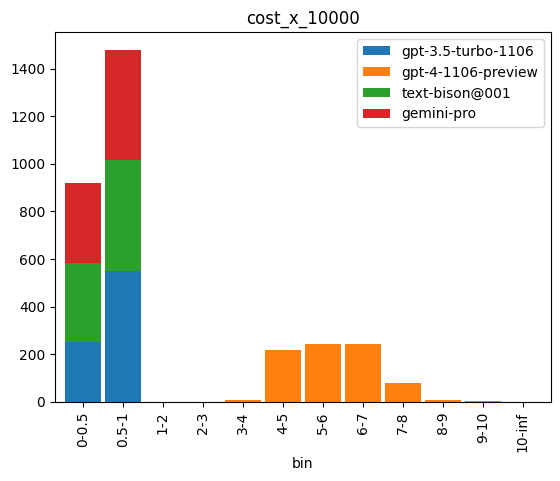

In [16]:
histplot(df=df_result, target_col='cost_x_10000', bins=[0, 0.5, *list(range(1, 11)), math.inf])

# 3-3. 処理時間

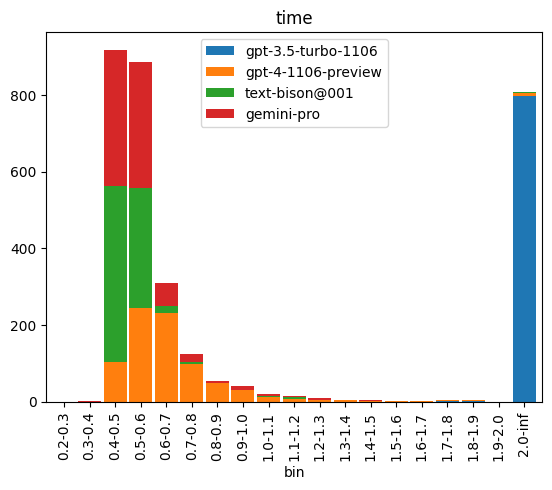

In [17]:
histplot(df=df_result, target_col='time', bins=[*[i / 10 for i in range(2, 20 + 1)], math.inf])